In [1]:
# libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from IPython.display import display
from numpy import where
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import OneClassSVM

In [2]:
# We might not need player_data.csv and players.csv since they are personal information that we can not make use of
salary_20 = pd.read_csv("salary_0020.csv")
salary_17 = pd.read_csv("salary_1718.csv")
stats = pd.read_csv("1950/seasons_stats.csv")
stats = stats.drop(stats.columns[0], axis=1)
pd.set_option('display.max_columns', None)


# Append salary to the dataframe
# Use the following attributes to fit models
# age, G, GS, MP, PER, TS, FTr, ORB%, DRB%, TRB%, AST%  STL%  BLK% TOV%  USG%, OWS  DWS, WS  WS/48, VORP, OBPM  DBPM  BPM and everything afterwards

team_names = {
    "Atlanta Hawks":"ATL",
    "Boston Celtics":"BOS",
    "Brooklyn Nets":"BKN",
    "Charlotte Hornets":"CHA",
    "Charlotte Bobcats":"CHB",
    "Chicago Bulls":"CHI",
    "Cleveland Cavaliers":"CLE",
    "Dallas Mavericks":"DAL",
    "Denver Nuggets":"DEN",
    "Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
    "Houston Rockets":"HOU",
    "Indiana Pacers":"IND",
    "LA Clippers":"LAC",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers":"LAL",
    "Memphis Grizzlies":"MEM",
    "Miami Heat":"MIA",
    "Milwaukee Bucks":"MIL",
    "Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
    "Oklahoma City Thunder":"OKC",
    "Orlando Magic":"ORL",
    "Philadelphia 76ers":"PHI",
    "Phoenix Suns":"PHX",
    "Portland Trail Blazers":"POR",
    "Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
    "Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
    "Washington Wizards":"WAS",
    "Seattle SuperSonics":"SEA",
    "Vancouver Grizzlies":"VAN",
    "New Jersey Nets":"NJN",
    "New Orleans Hornets":"NOK",
}

unknowns = [
    'Madrid Real Madrid',
    "null Unknown",
    "NO/Oklahoma City Hornets",
    'Bilbao Basket Bilbao Basket',
    "Fenerbahce Ulker Fenerbahce Ulker",
    "Maccabi Haifa Maccabi Haifa"
]

# Convert team names in 0020 dataset to abbreviations
for i in range(len(salary_20)):
    v = salary_20['team'][i]
    if v in unknowns:
        continue
    salary_20.loc[i,'team'] = team_names[v]

# Remove unknowns
for v in unknowns:
    salary_20 = salary_20[salary_20['team'] != v]

# Only use players from 2000 onward
stats = stats[stats['Year'] >= 2000]

# Add salary to stats dataset based on player, year
merged_00_to_17 = stats.merge(salary_20, left_on=['Year', 'Player', 'Tm'], right_on=['season', 'name', 'team'])

# Drop unused columns that we think are irrelevant from merged dataset
merged_00_to_17 = merged_00_to_17.drop(columns = ['Pos', 'Tm', '3PAr', 'blanl', 'blank2', 'rank', 'position', 'team', 'name', 'season'])

# display(salary_20.head(10))

# display(stats.head(10))

# display(merged_00_to_17.head(10))

# display(merged_00_to_17.tail(10))

# Different datasets to see what produces best predictions
# Can either always predict later year or split train, test throughout years

merged_10_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2010]

merged_13_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2013]

# Using 16 to predict 17

merged_16_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2016]

# Split within year

merged_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2017]

Visualize correlation using Heatmap

<Axes: >

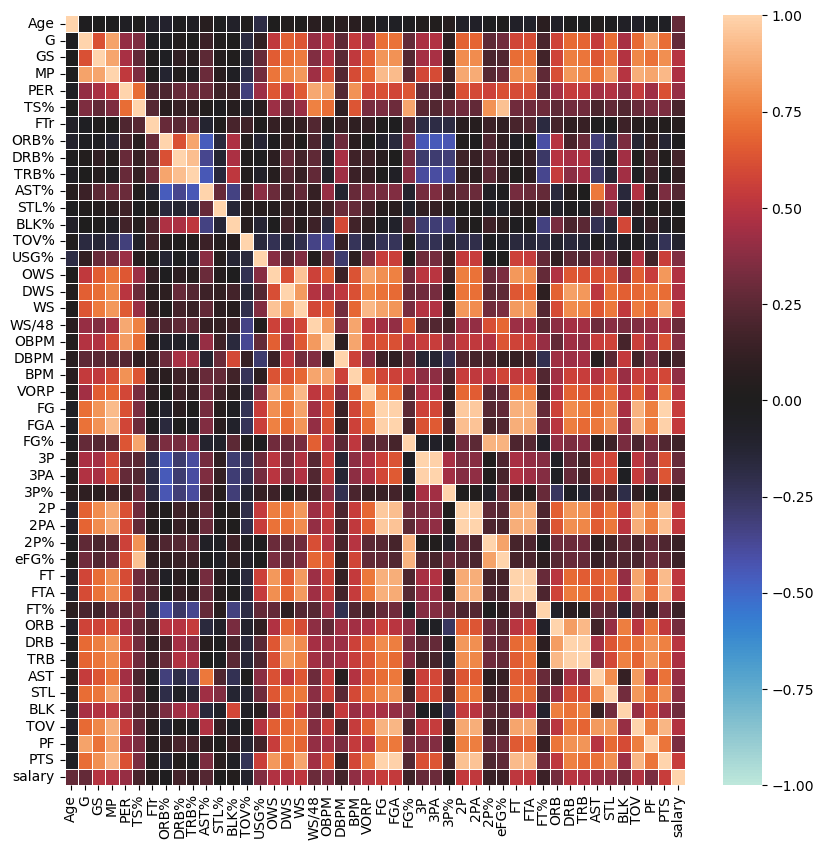

In [3]:
# heatmap for correlation
fig, ax = plt.subplots(figsize=(10, 10))

sb.heatmap(merged_00_to_17.drop(['Player', 'Year'], axis = 1).corr(), vmin=-1, vmax=1, center= 0, linewidths=.5, xticklabels=True, yticklabels=True)

Pairplot with MP

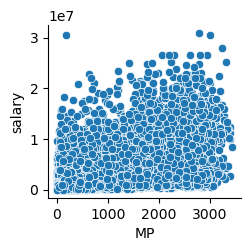

In [8]:
sb.pairplot(merged_00_to_17, x_vars = ["MP"], y_vars = ['salary'])
plt.show()

In [28]:
# Filter the most relevant attributes
filtered_0017 =  merged_00_to_17.drop(['Player', 'Year'], axis=1)

# Only need the salary column, and take out the correlation with salary itself
correlation = abs(filtered_0017.corr()['salary'][:-1])

# Get the sorted index of correlation
attribute_rank = np.argsort(correlation)

# Get the most relevant attributes
attribute_size = 8
relevant_attributes = attribute_rank.index[attribute_rank[-attribute_size:]]
print(relevant_attributes)

Index(['FT', 'FTA', 'WS', '2PA', 'FGA', '2P', 'PTS', 'FG'], dtype='object')


In [32]:
df_salary = merged_00_to_17.copy()
df_salary = pd.DataFrame(preprocessing.OrdinalEncoder().fit_transform(df_salary), columns=df_salary.columns)
# OrdinalEncoder will skip numerical values. LabelEncoder also works as they share the same functionality.
display(df_salary[['PTS', 'FTA', '2PA', 'FGA', 'WS', 'GS', 'salary']])

,PTS,FTA,2PA,FGA,WS,GS,salary
0,1415.0,503.0,1045.0,1174.0,102.0,82.0,2808.0
1,1460.0,393.0,947.0,1238.0,115.0,82.0,2808.0
2,60.0,4.0,81.0,95.0,7.0,0.0,202.0
3,1093.0,253.0,756.0,960.0,87.0,82.0,2552.0
4,980.0,253.0,552.0,771.0,63.0,82.0,1249.0
...,...,...,...,...,...,...,...
5987,801.0,86.0,568.0,682.0,60.0,74.0,3122.0
5988,178.0,39.0,157.0,158.0,24.0,5.0,2698.0
5989,23.0,5.0,31.0,31.0,14.0,0.0,548.0
5990,239.0,40.0,122.0,221.0,19.0,18.0,397.0


In [33]:
salary_train, salary_test = train_test_split(df_salary, test_size=0.2)
X_salary_train, y_salary_train = salary_train[['PTS', 'FTA', '2PA', 'FGA', 'WS', 'GS']], salary_train['salary']
X_salary_test, y_salary_test = salary_test[['PTS', 'FTA', '2PA', 'FGA', 'WS', 'GS']], salary_test['salary']
print(X_salary_train.shape, X_salary_test.shape)

(4793, 6) (1199, 6)



Degree: 1
Training RMSE: 813.2344427052676
Testing RMSE: 787.6272384270206
Training R2: -1.113922076703148
Testing R2: -1.0171639175414042


PTS



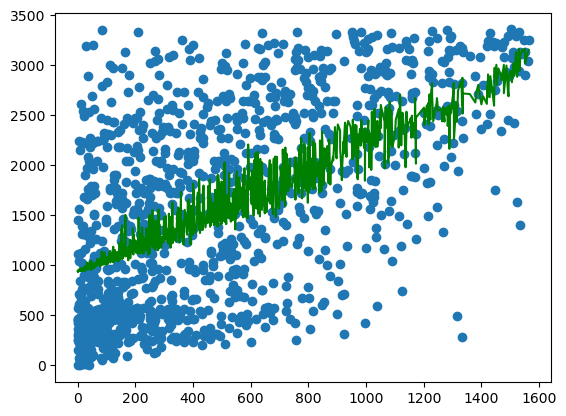


FTA



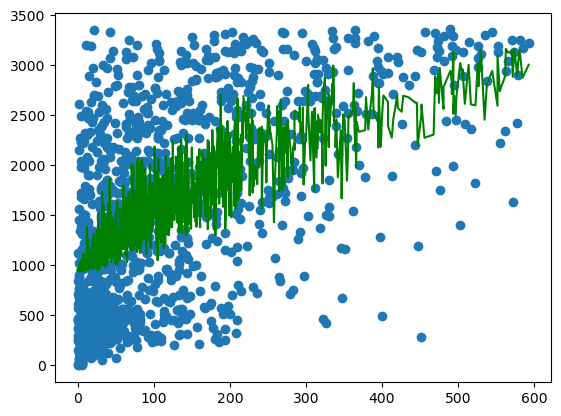


2PA



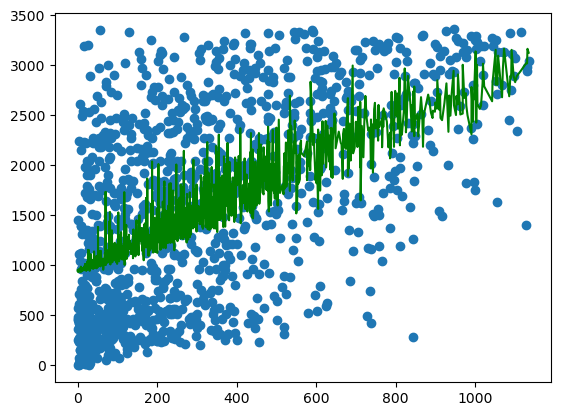


FGA



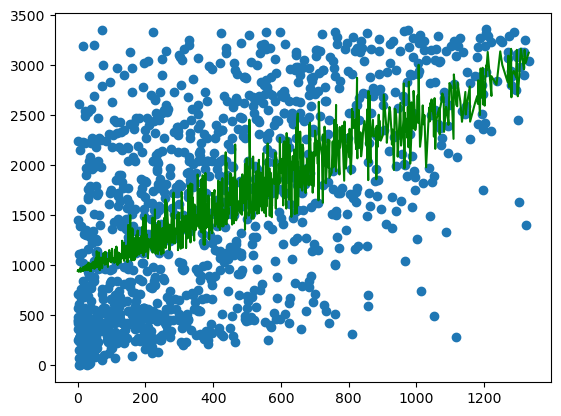


WS



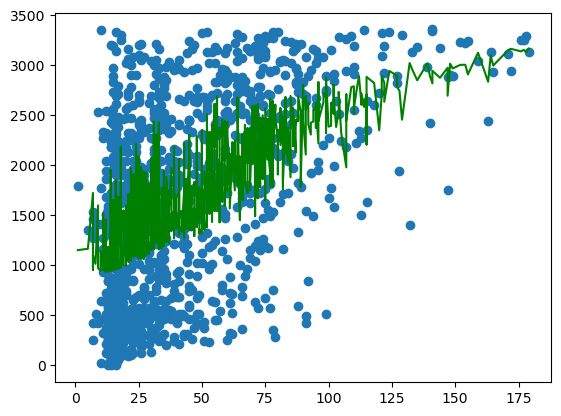


GS



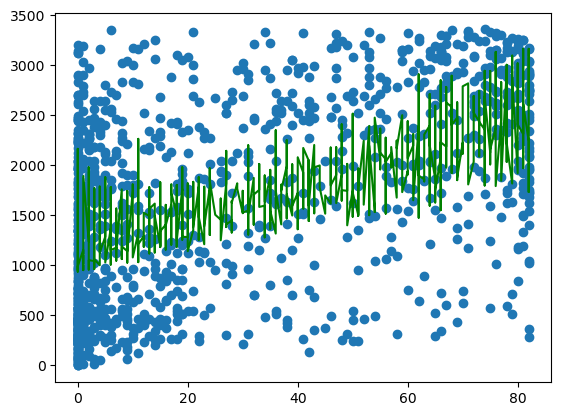


Degree: 2
Training RMSE: 800.3695057283475
Testing RMSE: 778.816814198738
Training R2: -0.9201600315200245
Testing R2: -0.8404319241992078


PTS



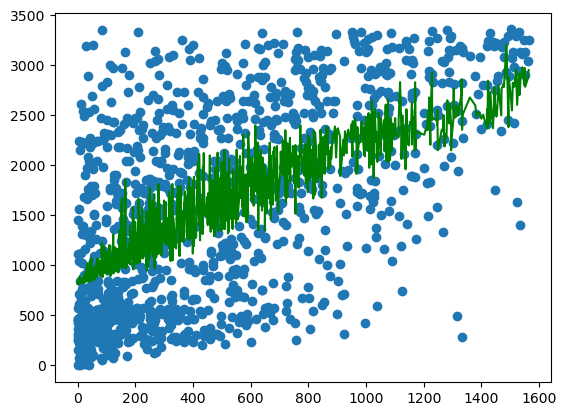


FTA



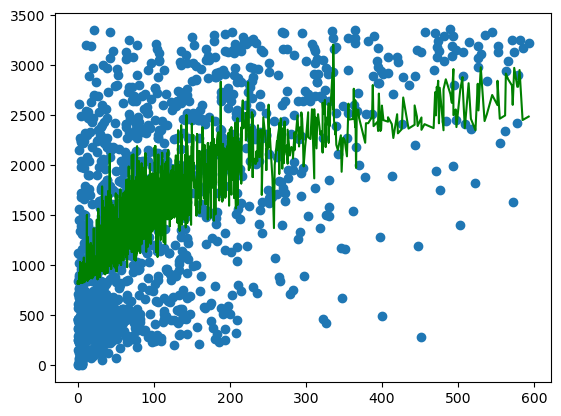


2PA



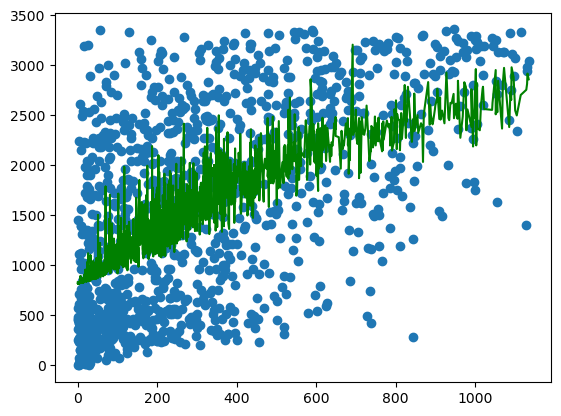


FGA



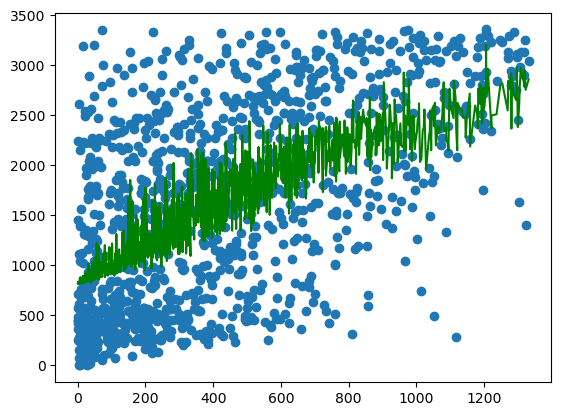


WS



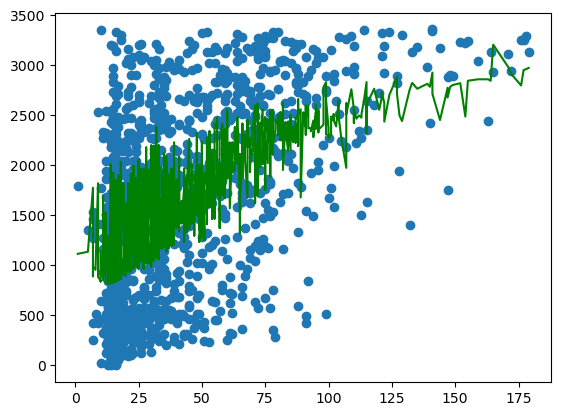


GS



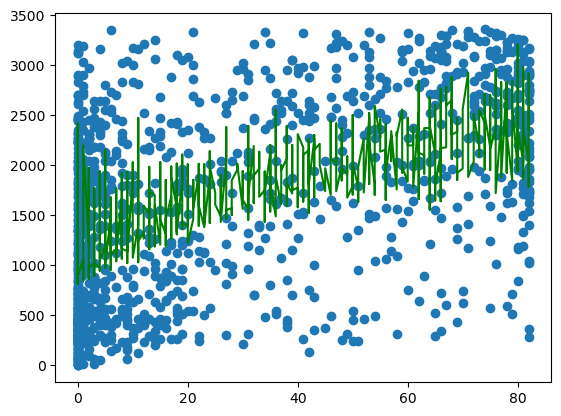


Degree: 3
Training RMSE: 791.9047563710733
Testing RMSE: 781.0711498816264
Training R2: -0.8067649052601742
Testing R2: -0.8016005967197364


PTS



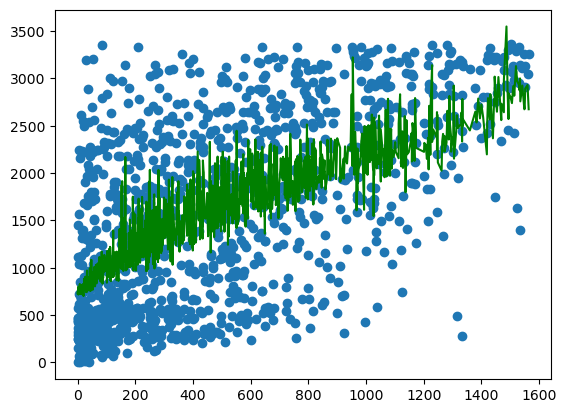


FTA



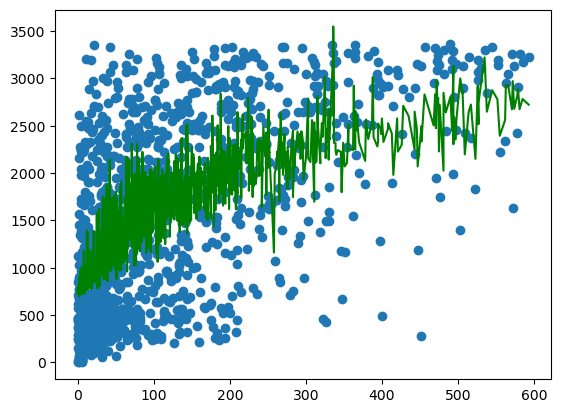


2PA



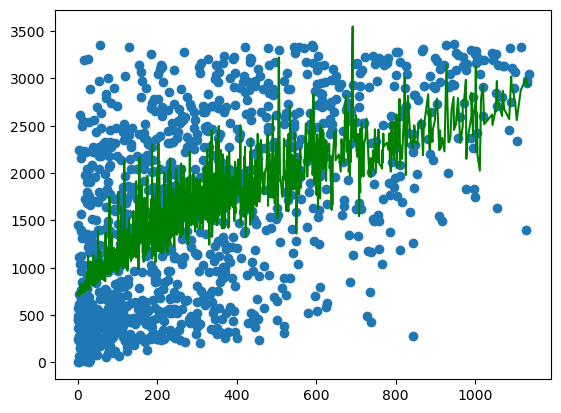


FGA



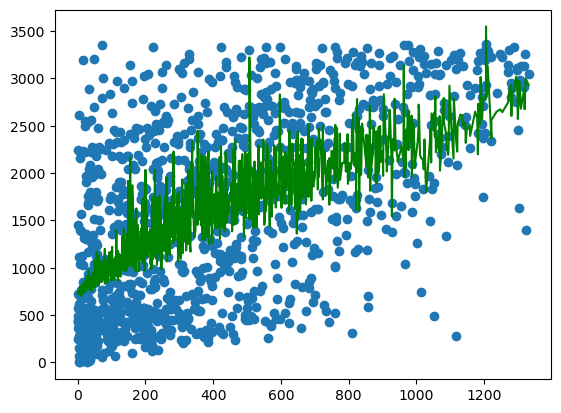


WS



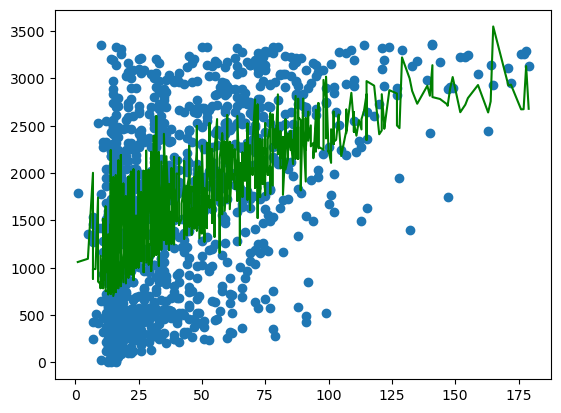


GS



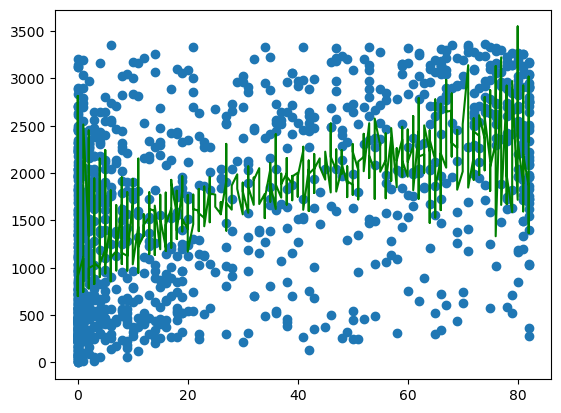


Degree: 4
Training RMSE: 773.3701733486015
Testing RMSE: 794.9023730349655
Training R2: -0.5902235741405919
Testing R2: -0.5989310096288818


PTS



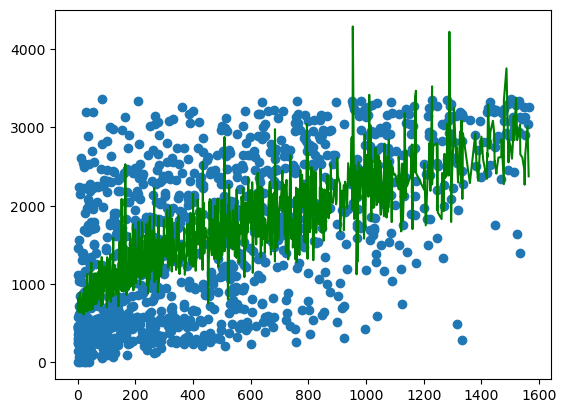


FTA



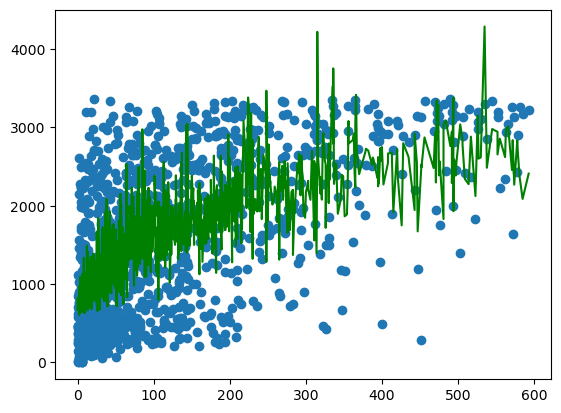


2PA



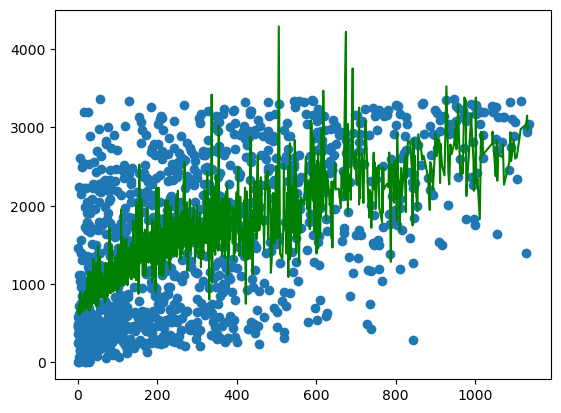


FGA



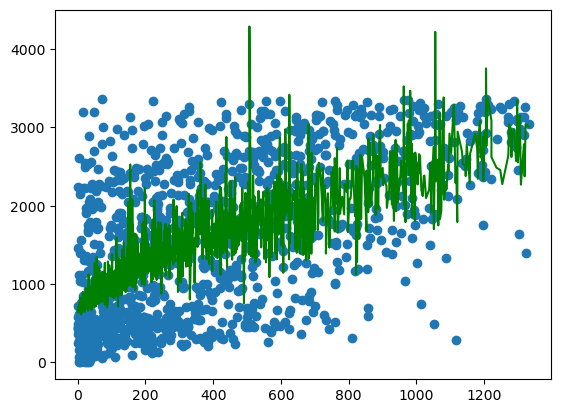


WS



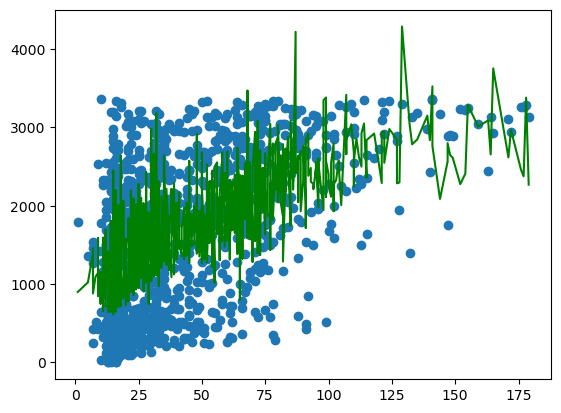


GS



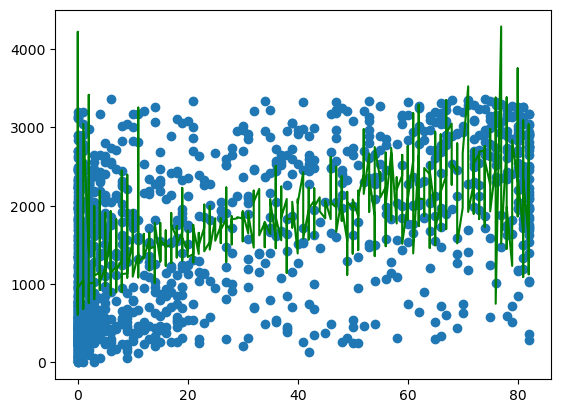

In [34]:
# polynomial regression model to predict salary based on PTS, FTA, 2PA, FGA, WS, GS 
# which were found to have some correlation to salary via heatmap

for i in range(1,5):
    poly = PolynomialFeatures(degree = i, include_bias = False)
    
    x_poly_train = poly.fit_transform(X_salary_train)
    x_poly_test = poly.fit_transform(X_salary_test)
    
    plr = LinearRegression().fit(x_poly_train, y_salary_train)

    train_poly_pred = plr.predict(x_poly_train)
    test_poly_pred = plr.predict(x_poly_test)
    print(f"\nDegree: {i}\nTraining RMSE: {math.sqrt(mean_squared_error(train_poly_pred, y_salary_train))}\nTesting RMSE: {math.sqrt(mean_squared_error(test_poly_pred, y_salary_test))}\nTraining R2: {r2_score(train_poly_pred, y_salary_train)}\nTesting R2: {r2_score(test_poly_pred, y_salary_test)}\n")
    
    for i in X_salary_test:
        print(f"\n{i}\n")
        x_pd = pd.Series(X_salary_test[i].values.flatten())
        y_pred_pd = pd.Series(test_poly_pred.flatten())

        x_sorted = x_pd.sort_values()

        Y_pred = np.array(y_pred_pd[x_sorted.index])
        x_arr = np.array(x_sorted)

        #plotting
        plt.scatter(X_salary_test[i], y_salary_test)
        plt.plot(x_arr, Y_pred, color='g')
        plt.show()